Loading cleaned data: cleaned_worldcup_matches.csv
Rows: 41794
Using features: ['goal_diff_home', 'goal_diff_away', 'home_score', 'away_score', 'home_advantage', 'year', 'win_rate_last10', 'wins_last10_count', 'form_score_last10', 'home_rank_proxy', 'away_rank_proxy', 'ranking_diff_proxy']
Train / Test shapes: (33435, 12) (8359, 12)
Labels: ['away_win', 'draw', 'home_win']
Loaded models from task2_results
Saved metrics summary to task3_results\metrics_summary.csv

Logistic Regression metrics:
 {'model': 'LogisticRegression', 'accuracy': 1.0, 'precision_macro': 1.0, 'recall_macro': 1.0, 'f1_macro': 1.0}

Random Forest metrics:
 {'model': 'RandomForest', 'accuracy': 1.0, 'precision_macro': 1.0, 'recall_macro': 1.0, 'f1_macro': 1.0}
Saved classification reports.
Saved: task3_results\cm_lr.png


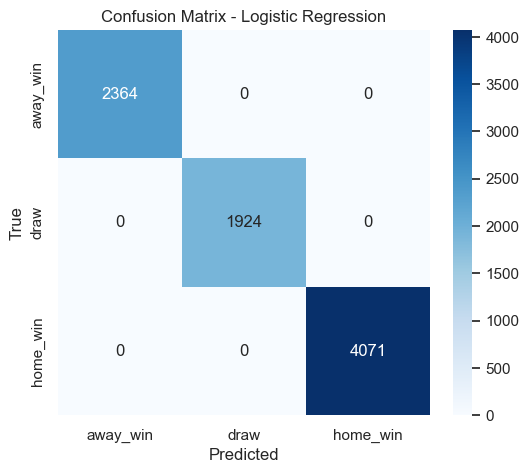

Saved: task3_results\cm_rf.png


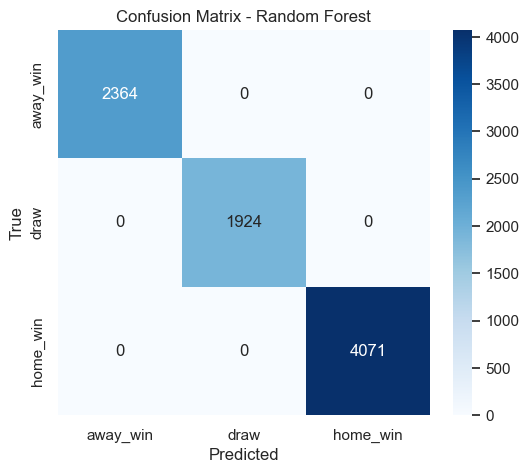

LR per-class AUCs: {'away_win': 0.9999999999999999, 'draw': 1.0, 'home_win': 1.0}
Saved: task3_results\roc_lr.png


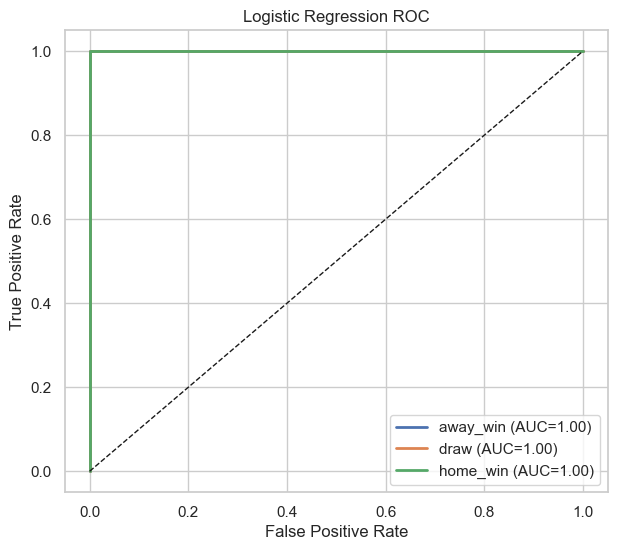

Saved: task3_results\pr_lr.png


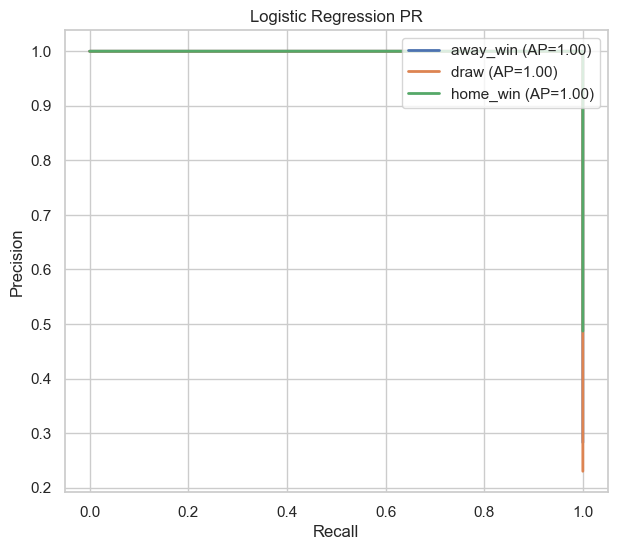

Saved: task3_results\lr_calibration.png


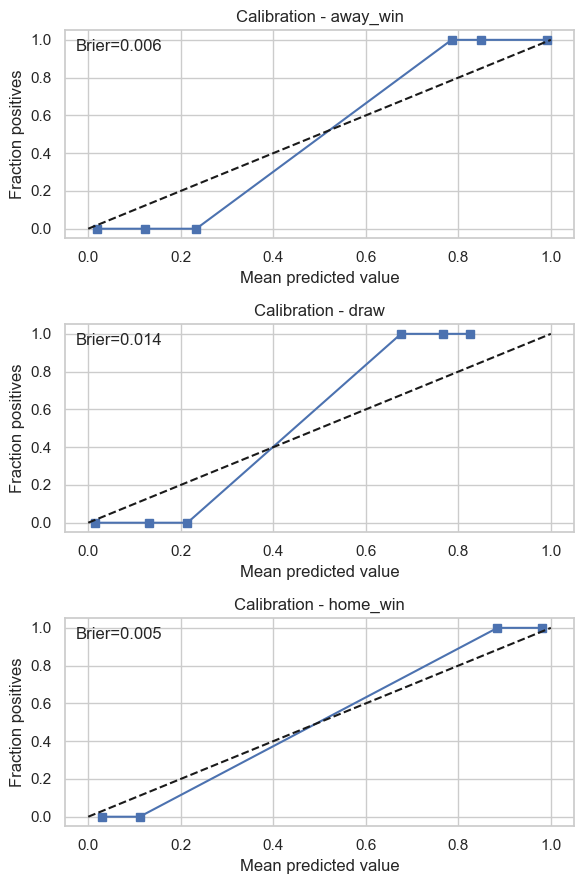

RF per-class AUCs: {'away_win': 1.0, 'draw': 1.0, 'home_win': 1.0}
Saved: task3_results\roc_rf.png


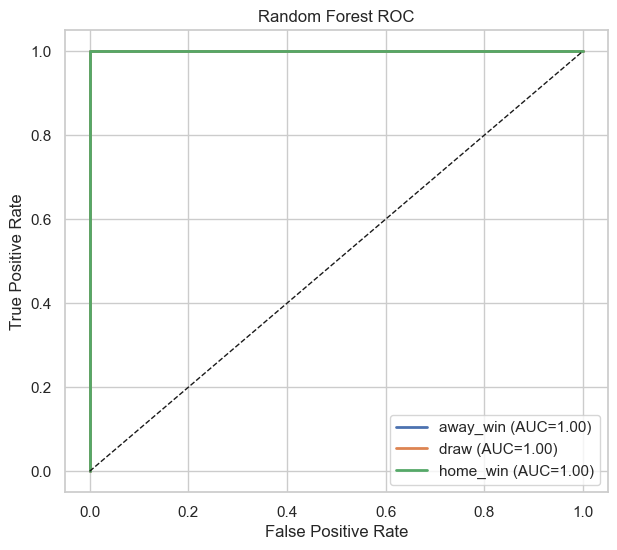

Saved: task3_results\pr_rf.png


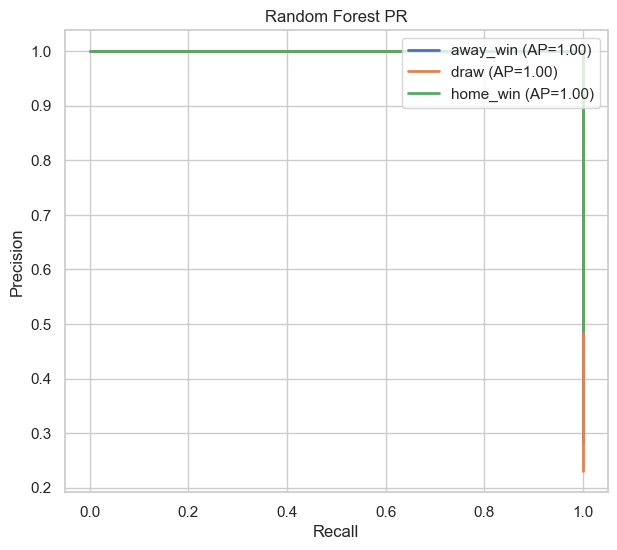

Saved: task3_results\rf_calibration.png


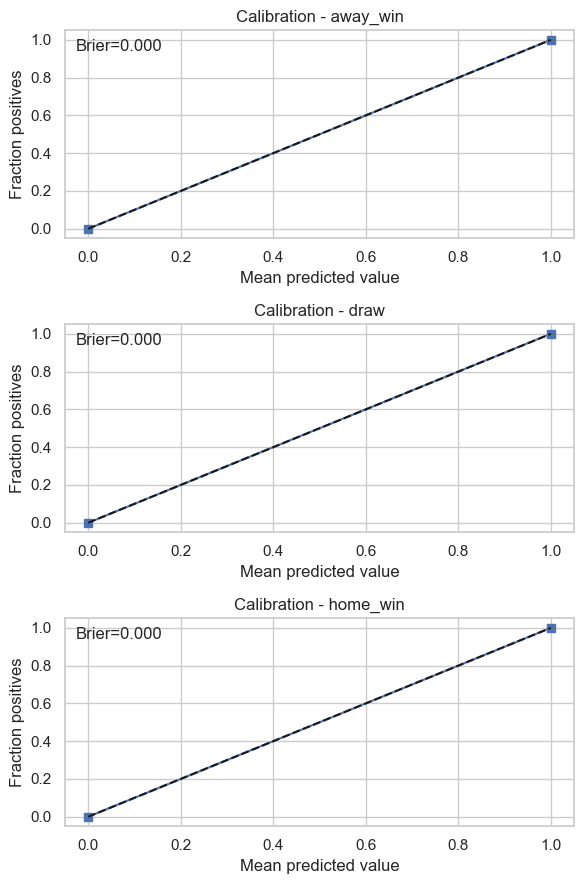

Mean F1 diff (LR - RF): 0.0 95% CI: (0.0, 0.0)
Contingency table: [[8359, 0], [0, 0]]
McNemar test statistic: inf p-value: 0.0
Saved per-sample predictions to task3_results\predictions_with_probs.csv

--- Quick Interpretation Notes (fill in report) ---
LR Accuracy: 1.000, F1_macro: 1.000
RF Accuracy: 1.000, F1_macro: 1.000
Mean F1 diff (LR - RF): 0.0 95% CI: (0.0, 0.0)
McNemar p-value: 0.0
Plots and detailed files saved to: task3_results


In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score, brier_score_loss)
from sklearn.calibration import calibration_curve
from statsmodels.stats.contingency_tables import mcnemar
import warnings
warnings.filterwarnings("ignore")


RANDOM_SEED = 42
RESULTS_DIR = "task3_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

CLEANED_CSV = "cleaned_worldcup_matches.csv"
MODEL_DIR = "task2_results"
LR_MODEL_PATH = os.path.join(MODEL_DIR, "best_logistic.joblib")
RF_MODEL_PATH = os.path.join(MODEL_DIR, "best_randomforest.joblib")


sns.set(style="whitegrid")

def save_fig(fig, fname):
    path = os.path.join(RESULTS_DIR, fname)
    fig.savefig(path, bbox_inches="tight")
    print("Saved:", path)

def plot_confusion(y_true, y_pred, labels, title, fname=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    if fname: save_fig(fig, fname)
    plt.show()

def plot_multiclass_roc(y_test_bin, y_prob, labels, title, fname=None):
    n_classes = y_test_bin.shape[1]
    fig, ax = plt.subplots(figsize=(7,6))
    for i in range(n_classes):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f"{labels[i]} (AUC={roc_auc:.2f})")
        except Exception as e:
            print("ROC skipped for", labels[i], "|", e)
    ax.plot([0,1],[0,1],"k--", lw=1)
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    if fname: save_fig(fig, fname)
    plt.show()

def plot_pr(y_test_bin, y_prob, labels, title, fname=None):
    n_classes = y_test_bin.shape[1]
    fig, ax = plt.subplots(figsize=(7,6))
    for i in range(n_classes):
        try:
            prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
            ax.plot(rec, prec, lw=2, label=f"{labels[i]} (AP={ap:.2f})")
        except Exception as e:
            print("PR skipped for", labels[i], "|", e)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title(title); ax.legend(loc="upper right")
    if fname: save_fig(fig, fname)
    plt.show()

def plot_calibration(y_test_bin, y_prob, labels, title_prefix):
    n = y_test_bin.shape[1]
    fig, axs = plt.subplots(nrows=n, figsize=(6, 3*n))
    if n == 1:
        axs = [axs]
    for i in range(n):
        try:
            prob_pos = y_prob[:, i]
            frac_pos, mean_pred = calibration_curve(y_test_bin[:, i], prob_pos, n_bins=10)
            axs[i].plot(mean_pred, frac_pos, "s-", label=f"{labels[i]}")
            axs[i].plot([0,1],[0,1],"k--")
            axs[i].set_ylim([-0.05,1.05])
            axs[i].set_ylabel("Fraction positives"); axs[i].set_xlabel("Mean predicted value")
            axs[i].set_title(f"Calibration - {labels[i]}")
            brier = brier_score_loss(y_test_bin[:, i], prob_pos)
            axs[i].text(0.02, 0.9, f"Brier={brier:.3f}", transform=axs[i].transAxes)
        except Exception as e:
            axs[i].text(0.1,0.5,f"Could not calibrate {labels[i]}: {e}")
    plt.tight_layout()
    fname = f"{title_prefix}_calibration.png"
    save_fig(fig, fname)
    plt.show()


print("Loading cleaned data:", CLEANED_CSV)
df = pd.read_csv(CLEANED_CSV)
print("Rows:", len(df))
# Determine features & target (similar to Task2)
possible_features = [
    'goal_diff_home', 'goal_diff_away', 'home_score', 'away_score',
    'home_advantage', 'year',
    'win_rate_last10', 'wins_last10_count', 'form_score_last10',
    'home_rank_proxy', 'away_rank_proxy', 'ranking_diff_proxy'
]
features = [c for c in possible_features if c in df.columns]
print("Using features:", features)
if 'match_outcome' in df.columns:
    y = df['match_outcome'].astype(str)
else:
    if 'outcome_numeric' in df.columns:
        y = df['outcome_numeric'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})
    else:
        raise ValueError("No target column found (match_outcome or outcome_numeric).")
X = df[features].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print("Train / Test shapes:", X_train.shape, X_test.shape)
labels = sorted(list(set(y_test)))
print("Labels:", labels)


def build_preprocessor(numeric_features):
    numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features)])
    return preprocessor

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = build_preprocessor(numeric_features)

best_lr = None
best_rf = None
if os.path.exists(LR_MODEL_PATH) and os.path.exists(RF_MODEL_PATH):
    try:
        best_lr = joblib.load(LR_MODEL_PATH)
        best_rf = joblib.load(RF_MODEL_PATH)
        print("Loaded models from", MODEL_DIR)
    except Exception as e:
        print("Failed to load models:", e)

if best_lr is None or best_rf is None:
    print("Saved models not found or failed to load. Training baseline models (this is a quick fallback).")
    # Build pipelines
    pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(random_state=RANDOM_SEED, multi_class='multinomial', solver='saga', max_iter=3000))])
    pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=200, n_jobs=-1))])
    # Fit
    pipe_lr.fit(X_train, y_train)
    pipe_rf.fit(X_train, y_train)
    best_lr = pipe_lr
    best_rf = pipe_rf
    joblib.dump(best_lr, os.path.join(RESULTS_DIR, "fallback_logistic.joblib"))
    joblib.dump(best_rf, os.path.join(RESULTS_DIR, "fallback_rf.joblib"))
    print("Saved fallback models to", RESULTS_DIR)


y_pred_lr = best_lr.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_prob_lr = None
y_prob_rf = None
try:
    y_prob_lr = best_lr.predict_proba(X_test)
except Exception as e:
    print("LR no predict_proba:", e)
try:
    y_prob_rf = best_rf.predict_proba(X_test)
except Exception as e:
    print("RF no predict_proba:", e)


def compute_metrics(y_true, y_pred):
    d = {}
    d['accuracy'] = accuracy_score(y_true, y_pred)
    d['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    d['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    d['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    d['report'] = classification_report(y_true, y_pred, zero_division=0)
    return d

metrics_lr = compute_metrics(y_test, y_pred_lr)
metrics_rf = compute_metrics(y_test, y_pred_rf)

summary = {
    'model': ['LogisticRegression', 'RandomForest'],
    'accuracy': [metrics_lr['accuracy'], metrics_rf['accuracy']],
    'precision_macro': [metrics_lr['precision_macro'], metrics_rf['precision_macro']],
    'recall_macro': [metrics_lr['recall_macro'], metrics_rf['recall_macro']],
    'f1_macro': [metrics_lr['f1_macro'], metrics_rf['f1_macro']]
}
summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join(RESULTS_DIR, "metrics_summary.csv"), index=False)
print("Saved metrics summary to", os.path.join(RESULTS_DIR, "metrics_summary.csv"))
print("\nLogistic Regression metrics:\n", summary_df.iloc[0].to_dict())
print("\nRandom Forest metrics:\n", summary_df.iloc[1].to_dict())


with open(os.path.join(RESULTS_DIR, "classification_report_lr.txt"), "w") as f:
    f.write(metrics_lr['report'])
with open(os.path.join(RESULTS_DIR, "classification_report_rf.txt"), "w") as f:
    f.write(metrics_rf['report'])
print("Saved classification reports.")


plot_confusion(y_test, y_pred_lr, labels, "Confusion Matrix - Logistic Regression", fname="cm_lr.png")
plot_confusion(y_test, y_pred_rf, labels, "Confusion Matrix - Random Forest", fname="cm_rf.png")


y_test_bin = label_binarize(y_test, classes=labels)

if y_prob_lr is not None:
    aucs_lr = {}
    for i, lab in enumerate(labels):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_lr[:, i])
            aucs_lr[lab] = auc(fpr, tpr)
        except Exception:
            aucs_lr[lab] = np.nan
    print("LR per-class AUCs:", aucs_lr)
    plot_multiclass_roc(y_test_bin, y_prob_lr, labels, "Logistic Regression ROC", fname="roc_lr.png")
    plot_pr(y_test_bin, y_prob_lr, labels, "Logistic Regression PR", fname="pr_lr.png")
    plot_calibration(y_test_bin, y_prob_lr, labels, "lr")
else:
    print("Logistic Regression probabilities not available; skipping ROC/PR/Calibration.")

if y_prob_rf is not None:
    aucs_rf = {}
    for i, lab in enumerate(labels):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
            aucs_rf[lab] = auc(fpr, tpr)
        except Exception:
            aucs_rf[lab] = np.nan
    print("RF per-class AUCs:", aucs_rf)
    plot_multiclass_roc(y_test_bin, y_prob_rf, labels, "Random Forest ROC", fname="roc_rf.png")
    plot_pr(y_test_bin, y_prob_rf, labels, "Random Forest PR", fname="pr_rf.png")
    plot_calibration(y_test_bin, y_prob_rf, labels, "rf")
else:
    print("Random Forest probabilities not available; skipping ROC/PR/Calibration.")


# Bootstrap CI for difference in macro-F1 (LR - RF)
def bootstrap_diff_f1(y_true, pred_a, pred_b, n_boot=1000, random_state=RANDOM_SEED):
    rng = np.random.RandomState(random_state)
    diffs = []
    n = len(y_true)
    y_true_arr = np.array(y_true)
    pred_a = np.array(pred_a)
    pred_b = np.array(pred_b)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        fa = f1_score(y_true_arr[idx], pred_a[idx], average='macro', zero_division=0)
        fb = f1_score(y_true_arr[idx], pred_b[idx], average='macro', zero_division=0)
        diffs.append(fa - fb)
    diffs = np.array(diffs)
    return diffs.mean(), (np.percentile(diffs, 2.5), np.percentile(diffs, 97.5))

mean_diff, ci = bootstrap_diff_f1(y_test.reset_index(drop=True), y_pred_lr, y_pred_rf, n_boot=1000)
print("Mean F1 diff (LR - RF):", mean_diff, "95% CI:", ci)
with open(os.path.join(RESULTS_DIR, "bootstrap_f1_diff.txt"), "w") as f:
    f.write(f"mean_diff: {mean_diff}\n95% CI: {ci}\n")

# McNemar test: table of disagreements (correct vs incorrect)
y_true_arr = np.array(y_test)
correct_lr = (y_pred_lr == y_true_arr)
correct_rf = (y_pred_rf == y_true_arr)
b = np.sum((correct_lr == True) & (correct_rf == False))  # LR correct only
c = np.sum((correct_lr == False) & (correct_rf == True))  # RF correct only
table = [[np.sum((correct_lr==True)&(correct_rf==True)), b],
         [c, np.sum((correct_lr==False)&(correct_rf==False))]]
print("Contingency table:", table)
# McNemar test requires off-diagonal counts:
res = mcnemar(table=[[table[0][0], table[0][1]],[table[1][0], table[1][1]]], exact=False)
with open(os.path.join(RESULTS_DIR, "mcnemar.txt"), "w") as f:
    f.write(f"statistic: {res.statistic}, pvalue: {res.pvalue}\ncontingency: {table}\n")
print("McNemar test statistic:", res.statistic, "p-value:", res.pvalue)


out_df = X_test.copy().reset_index(drop=True)
out_df['y_true'] = y_test.reset_index(drop=True)
out_df['pred_lr'] = y_pred_lr
out_df['pred_rf'] = y_pred_rf
if y_prob_lr is not None:
    # save probability columns prefixed by model
    for i, lab in enumerate(labels):
        out_df[f'prob_lr_{lab}'] = y_prob_lr[:, i]
if y_prob_rf is not None:
    for i, lab in enumerate(labels):
        out_df[f'prob_rf_{lab}'] = y_prob_rf[:, i]

out_df.to_csv(os.path.join(RESULTS_DIR, "predictions_with_probs.csv"), index=False)
print("Saved per-sample predictions to", os.path.join(RESULTS_DIR, "predictions_with_probs.csv"))


print("\n--- Quick Interpretation Notes (fill in report) ---")
print(f"LR Accuracy: {metrics_lr['accuracy']:.3f}, F1_macro: {metrics_lr['f1_macro']:.3f}")
print(f"RF Accuracy: {metrics_rf['accuracy']:.3f}, F1_macro: {metrics_rf['f1_macro']:.3f}")
print("Mean F1 diff (LR - RF):", mean_diff, "95% CI:", ci)
print("McNemar p-value:", res.pvalue)
print("Plots and detailed files saved to:", RESULTS_DIR)
